In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
from statsmodels.tsa.stattools import adfuller
from functions.find_bubbles import ADF, PSY, ADFres, cvPSYwmboot

## Detecting bubbles

Based on: https://itamarcaspi.github.io/psymonitor/articles/illustrationSNP.html

In [2]:
snp = pd.read_csv('snp.csv', index_col='date')

In [3]:
y = 1 / snp.value

In [4]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

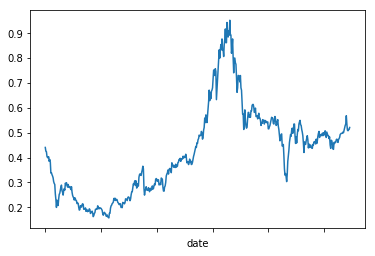

In [5]:
y.plot()

Next, we run the test and simulate critical values via the bootstrap.

In [6]:
bsadfs = PSY(y, swindow0, IC, adflag)
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=199)

The identified origination and termination dates can be calculated and viewed with the following commands:

In [65]:
monitorDates = snp.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]

Identify the start and end dates

In [87]:
periods

Index([u'1986-05-30', u'1986-06-30', u'1987-07-31', u'1987-08-31',
       u'1996-01-31', u'1996-05-31', u'1996-11-29', u'1996-12-31',
       u'1997-01-31', u'1997-02-28', u'1997-04-30', u'1997-05-30',
       u'1997-06-30', u'1997-07-31', u'1997-08-29', u'1997-09-30',
       u'1997-10-31', u'1997-11-28', u'1997-12-31', u'1998-01-30',
       u'1998-02-27', u'1998-03-31', u'1998-04-30', u'1998-05-29',
       u'1998-06-30', u'1998-07-31', u'1998-09-30', u'1998-10-30',
       u'1998-11-30', u'1998-12-31', u'1999-01-29', u'1999-02-26',
       u'1999-03-31', u'1999-04-30', u'1999-05-31', u'1999-06-30',
       u'1999-07-30', u'1999-08-31', u'1999-09-30', u'1999-10-29',
       u'1999-11-30', u'1999-12-31', u'2000-01-31', u'2000-02-29',
       u'2000-03-31', u'2000-04-28', u'2000-05-31', u'2000-06-30',
       u'2000-07-31', u'2000-08-31', u'2000-09-29', u'2000-10-31',
       u'2000-12-29', u'2001-01-31', u'2008-10-31', u'2008-11-28',
       u'2008-12-31', u'2009-01-30', u'2009-02-27'],
      dty

In [86]:
pd.to_datetime(periods)[0]

Timestamp('1986-05-30 00:00:00')

In [33]:
if not periods:
    raise ValueError('No bubble or crisis periods found.')

v = len(periods)
# create empty DF
dateStamps = pd.DataFrame()
#  random sample from obs with replacement
rN = np.random.choice(obs, v, replace=True)

# check the date is the next in the monitorDates list
for j in range(v):
    if (periods[j, 1] == periods[j, 2]):
    newEntry <- data.frame(start = OT[j, 1], end = OT[j, 1])
    dateStamps <- rbind(dateStamps, newEntry)

    } else {
      newEntry <- data.frame(start = OT[j, 1],
                             end = OT[j, 2])
      dateStamps <- rbind(dateStamps, newEntry)

    }
  }
  dateStamps
}

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Bootstrap time series using cvPSYwmboot

In [185]:
qe =  np.array([0.90, 0.95, 0.99])

beta, eps, lag = ADFres(y, IC, adflag)

T0 = len(eps)
t = len(y)
dy = np.array(y.iloc[0:(t - 1)]) - np.array(y.iloc[1:t])
g = len(beta)

# create matrix filled with random ints < T0 with rows TB and cols: nboot
rN = np.random.randint(0, T0, (Tb, nboot))
# create weigth matrix filled a random normal float
wn = np.random.normal(0) * np.ones([Tb, nboot])

# dyb = 69 row, 99 col matrix of zeros
dyb = np.zeros([Tb - 1, nboot])
# fill first 6 rows with first six 
dyb[:lag + 1, ] = np.split(np.tile(dy[[l for l in range(lag + 1)]], nboot), lag + 1, axis=0)

for j in range(nboot):
    # loop over all columns
    if lag == 0:
        for i in range(lag, Tb - 1):
            # loop over rows, start filling the rest of the dyb rows with random numbers
            dyb[i, j] = wn[i - lag, j] * eps[rN[i - lag, j]]
    elif lag > 0:
        x = np.zeros([Tb - 1, lag])
        for i in range(lag, Tb - 1):
            # create a new empy array of simlar proportions to dyb
            x = np.zeros([Tb - 1, lag])
            for k in range(lag):
                # every row after the first 6, fill the first six column values with  
                # values of the dyb six rows that came before it
                x[i, k] = dyb[i - k, j]

            # matrix multiplication 
            # fill the rows below the first 6 with 
            # the i row of x * 
            dyb[i, j] = np.dot(x[i, ], beta[1:g]) + wn[i - lag, j] * eps[rN[i - lag, j]]

dyb0 = np.ones([Tb, nboot]) * y[1]
dyb0[1:, :] = dyb
yb = np.cumsum(dyb0, axis=0)

dim = Tb - swindow0 + 1
i = 0

## Implementing the functions etc to detect bubbles

In [186]:
# for every .. column perform PSY, since there are 99 columns...
# this gives a new matrix with 24 columns and 4 rows... so every row= ser 
MPSY = []
for col in range(nboot):
    MPSY.append(PSY(pd.Series(yb[:,col]), swindow0, IC, adflag))

MPSY = np.array(MPSY)
# then, find the max value for each point in time?
SPSY = MPSY.max(axis=1)
# then, find the quantile for each
Q_SPSY = pd.Series(SPSY.T[0]).quantile(qe)

In [188]:
Q_SPSY

0.90    0.721226
0.95    0.866619
0.99    1.248693
dtype: float64

In [80]:
def PSY(y, swindow0, adflag):
    """
    Estimate PSY's BSADF sequence of test statistics
    implements the real time bubble detection procedure of Phillips, Shi and Yu (2015a,b)
    
    param: y: np.array of the data
    param: swindow0: integer minimum window size 
    param: adflag: An integer, lag order when IC=0; maximum number of lags when IC>0 (default = 0).
    
    For every period in time calculate the max ADF statistic using a rolling window. 
    
    return: list BSADF test statistic.
    """
    t = len(y)
    
    if not swindow0: 
        swindow0 = int(math.floor(t * (0.01 + 1.8 / np.sqrt(t))))

    bsadfs = np.zeros([t, 1]) # create empty column array at lenght of the data (zeros)

    for r2 in range(swindow0, t + 1):
    # loop over the range 47 - 647
    # create column vector of increasing lenght and fill with - 999
        rwadft = np.ones([r2 - swindow0 + 1, 1]) * -999
        for r1 in range(r2 - swindow0 + 1):
            # loop over the range 0 - 500
            # perform ADF test on data from r1 --> r2
            # insert in row
            rwadft[r1] = float(adfuller(y.iloc[r1:r2], maxlag=adflag, autolag='BIC')[0]) # two tail 5% significant level
        
        # take max value an insert in bsadfs array
        bsadfs[r2 - 1] = max(rwadft.T[0])

    # create shortened version of array
    bsadf = bsadfs[swindow0:t]
    
    return bsadf

In [ ]:
def cvPSYwmboot(y, swindow0, adflag, Tb, nboot, nCores = 2):  # IC = 'BIC'
    """
    Computes a matrix of 90, 95 and 99 critical values which can be used to compare to the bsadf statistics.
    
    
    
    return: A matrix. BSADF bootstrap critical value sequence at the 90, 95 and 99 percent level.
    """